# Imports & Setup

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib
import curie as ci
import numpy as np
import pandas as pd
from path import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from stack_analysis import StackAnalysis
from cs_analysis import CrossSectionAnalysis
from spectrum_analysis import SpectrumAnalysis
from uncertainties import correlated_values, unumpy

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14,
                            'axes.labelsize':   13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (14, 8)})


root_path = Path.cwd().parent 
spec_filename   = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path   = spec_filename / 'experiment'
spec_test_path  = spec_filename / 'test'
tendl_data_path = root_path / 'tendl_data'
fig_path        = root_path / 'figs'

[autoreload of curie.data failed: Traceback (most recent call last):
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'curie' not in sys.modules
]
[autoreload of curie.plotting failed: Traceback (most recent call last):
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 475, in superrelo

[autoreload of curie.data failed: Traceback (most recent call last):
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'curie' not in sys.modules
]
[autoreload of curie.plotting failed: Traceback (most recent call last):
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\krist\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 475, in superrelo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calibration

### Plotting Efficiency Curve

In [4]:
calib_path_Cs = spec_calib_path / 'AA110625_Cs137.Spe'
calib_path_Ba = spec_calib_path / 'AB110625_Ba133.Spe'
calib_path_Eu = spec_calib_path / 'AC110625_Eu152.Spe'

# Extract the spectrums for calibration
cb = ci.Calibration()
sp_Cs137 = ci.Spectrum(calib_path_Cs)
sp_Ba133 = ci.Spectrum(calib_path_Ba)
sp_Eu152 = ci.Spectrum(calib_path_Eu)

# Assign isotopes to the spectrums. Our calibration samples are 100% Cs137, Ba133, and Eu152
# Note: Isotope names must be uppercase
sp_Cs137.isotopes = ['137CS']
sp_Ba133.isotopes = ['133BA']
sp_Eu152.isotopes = ['152EU']


def Ci_to_Bq(Ci: float) -> float:
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10  # 1 Ci = 3.7e10 Bq

# Add information about the sources
# Note: Isotope names must be uppercase
sources = [
    {'isotope': '133BA',
     'A0': Ci_to_Bq(10.78*1e-6),
     'ref_date': '10/01/1988 12:00:00'},
    {'isotope': '137CS', 
     'A0': Ci_to_Bq(11.46*1e-6), 
     'ref_date': '02/01/1979 12:00:00'},
    {'isotope': '152EU',
     'A0': 150*1e3,
     'ref_date': '01/01/2002 12:00:00'}
]

sources = pd.DataFrame(sources)

# IMPORTANT: If calibration is not successful, run cell again with `sp_Eu152.auto_calibrate()` uncommented 
# sp_Eu152.auto_calibrate()
cb.calibrate([sp_Ba133, sp_Cs137, sp_Eu152], sources=sources)

# cb.saveas(root_path / 'calibration.json')

Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AA110625_Cs137.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AB110625_Ba133.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AC110625_Eu152.Spe


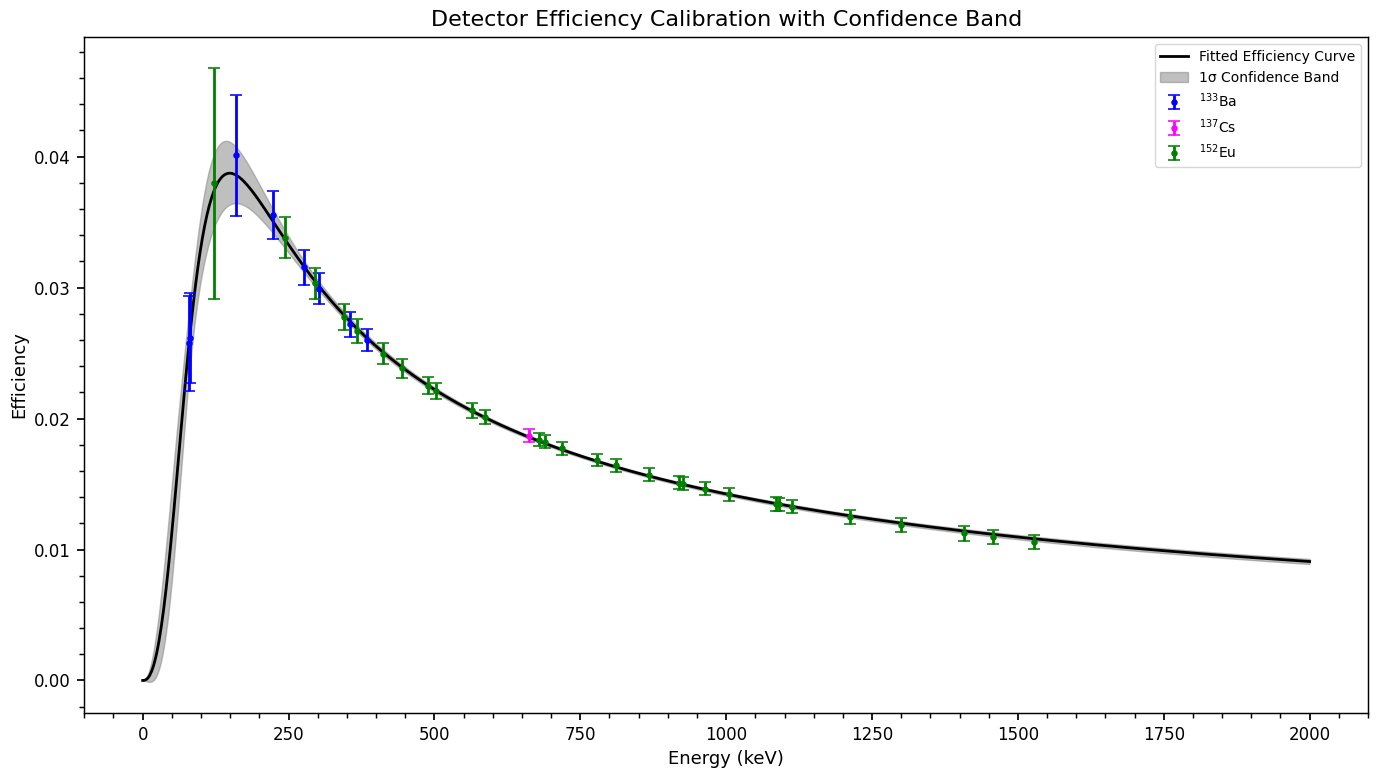

In [5]:
isotope_energy_set = []
efficiencies = []
unc_efficiencies = []
isotopes = []

for sp in [sp_Ba133, sp_Cs137, sp_Eu152]:
    if sp.peaks is None:
        raise ValueError(f"Peaks not found in spectrum {sp.filename}. Ensure the spectrum is calibrated and has peaks detected.")
    
    for energy, ε, unc_ε, iso_name in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        isotope_energy_set.append(energy)
        efficiencies.append(ε)
        unc_efficiencies.append(unc_ε)
        isotopes.append(iso_name)

isotope_energy_set = np.array(isotope_energy_set)
efficiencies = np.array(efficiencies)
unc_efficiencies = np.array(unc_efficiencies)
        
def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)

# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters from testing parameters manually
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, p0=[20, 1, 5e+4, 2], sigma=unc_efficiencies, absolute_sigma=True)

energy_range = np.linspace(0, 2000, 1000)
fitted_efficiency = efficiency_curve(energy_range, *efficiency_curve_params)

# Create correlated ufloat objects for the fitted parameters
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
# Calculate the fitted efficiency with uncertainties
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
# Extract nominal values and standard deviations
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)



# Plotting the confidence band
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

plt.errorbar(sp_Ba133.peaks['energy'], sp_Ba133.peaks['efficiency'], yerr=sp_Ba133.peaks['unc_efficiency'], fmt='o', label=r'$^{133}$Ba', color='blue')
plt.errorbar(sp_Cs137.peaks['energy'], sp_Cs137.peaks['efficiency'], yerr=sp_Cs137.peaks['unc_efficiency'], fmt='o', label=r'$^{137}$Cs', color='magenta')
plt.errorbar(sp_Eu152.peaks['energy'], sp_Eu152.peaks['efficiency'], yerr=sp_Eu152.peaks['unc_efficiency'], fmt='o', label=r'$^{152}$Eu', color='green')

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

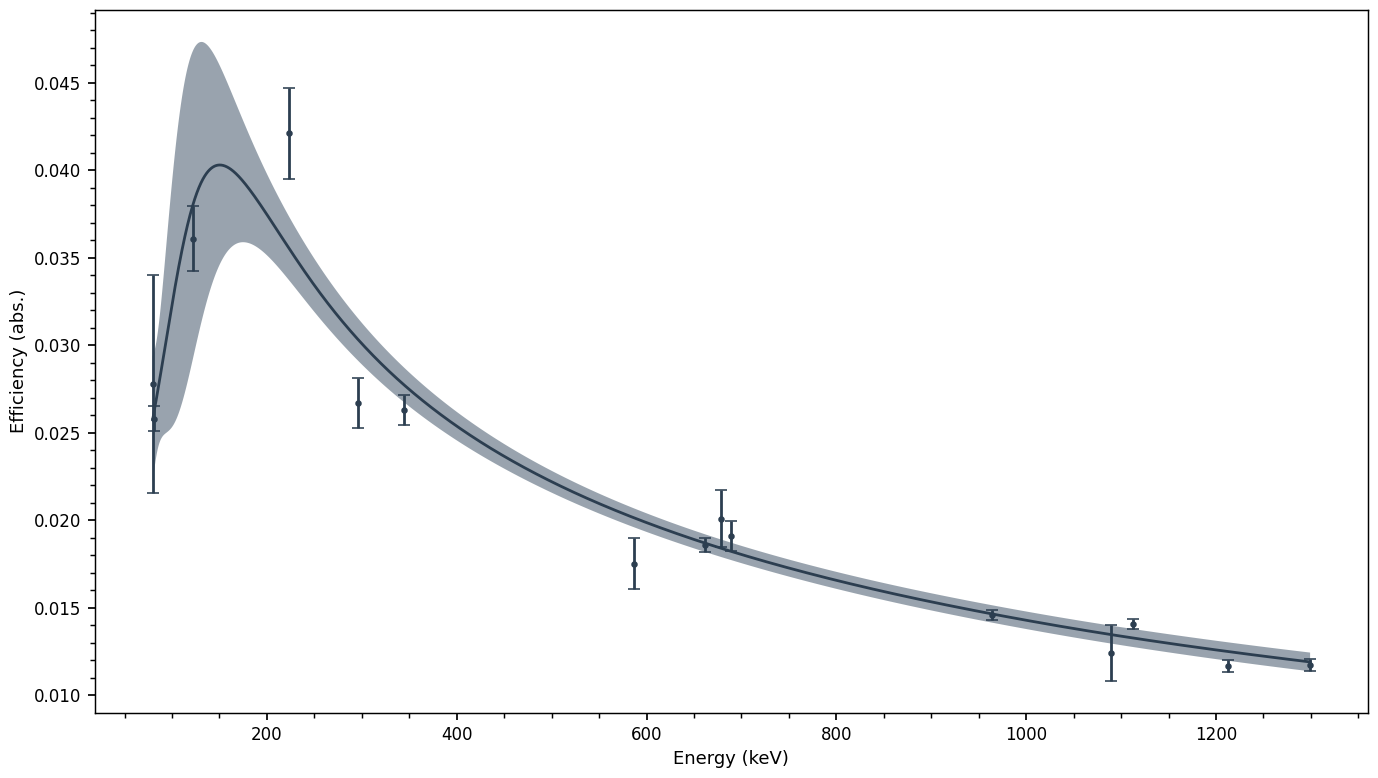

In [6]:
cb.plot_effcal()

# Part 1: Finding Initial Activity

## Analysis

### Job 1:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

In [7]:
analysis_1 = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)

Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of

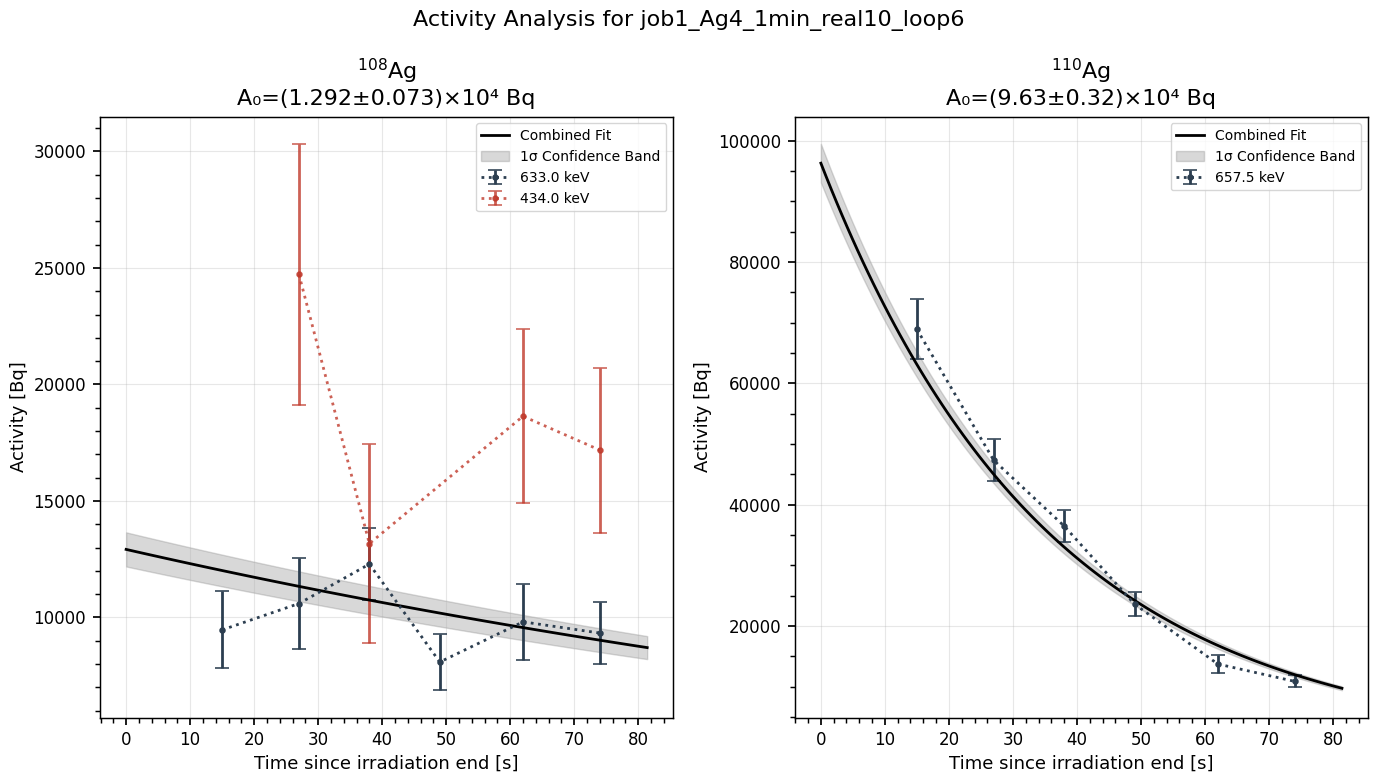

In [8]:
analysis_1.plot_activity()

### Job 2:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

In [11]:
analysis_2 = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)

Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_004.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_005.Spe


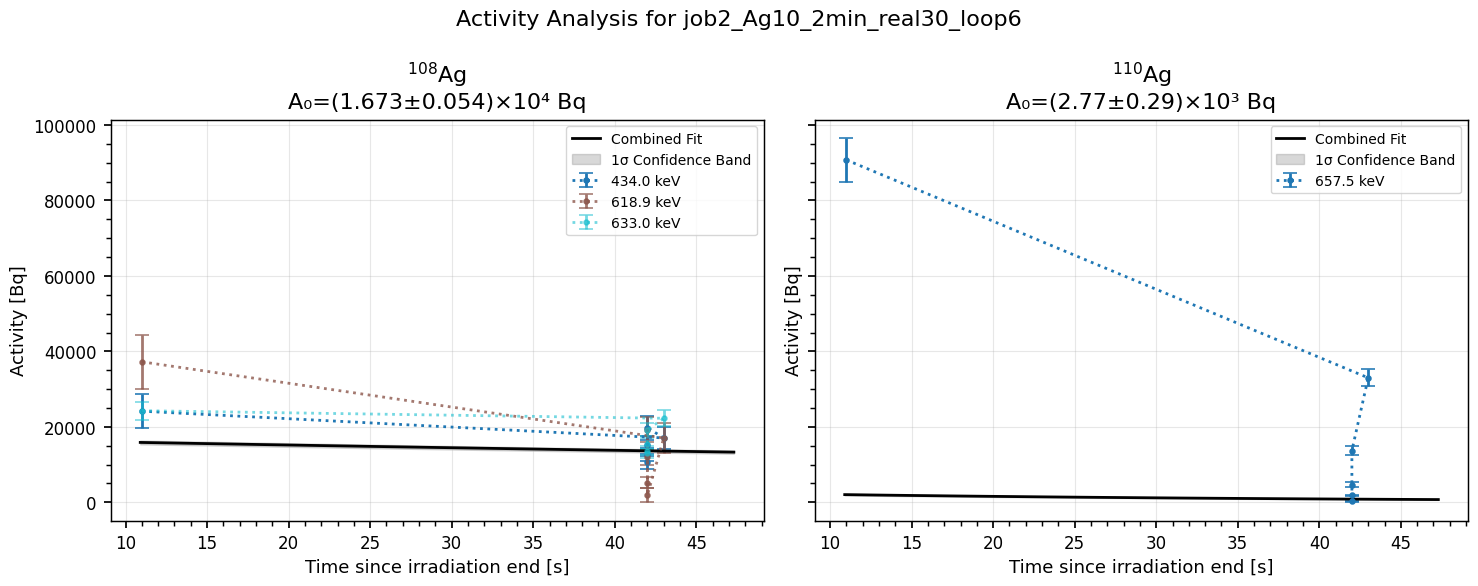

In [12]:
analysis_2.plot_activity()

### Job 3:
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

In [13]:
analysis_3 = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)

Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_002.Spe


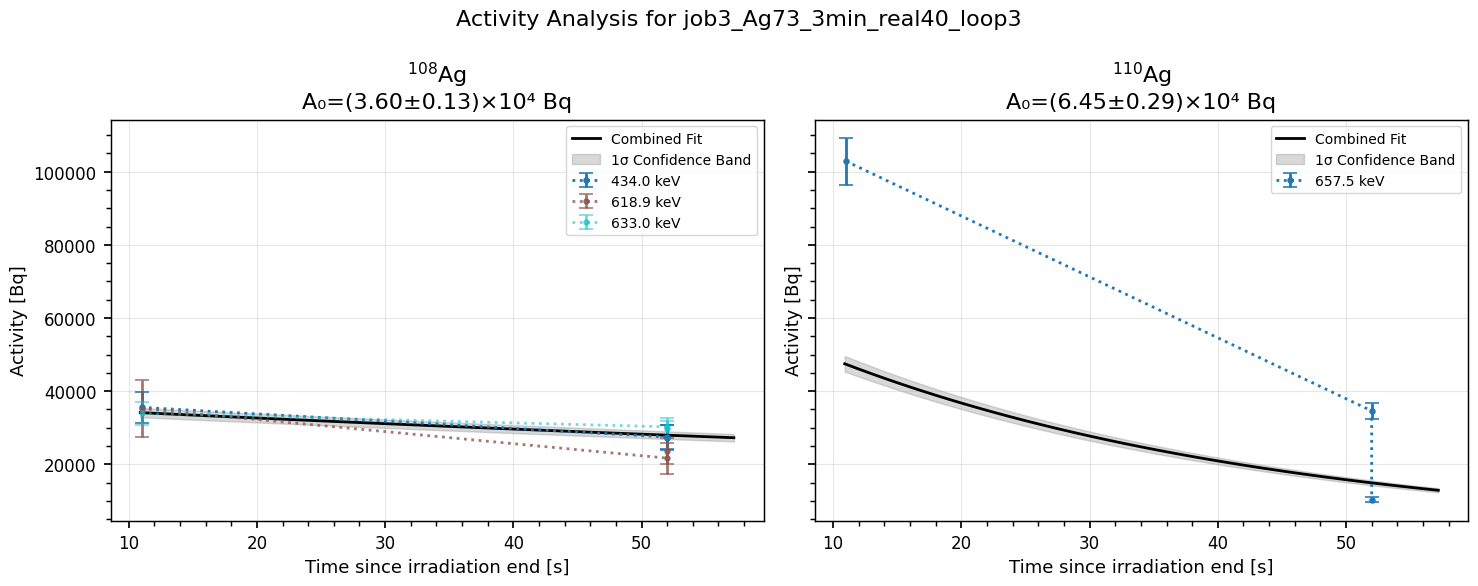

In [14]:
analysis_3.plot_activity()

### Job 4:
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

In [15]:
analysis_4 = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)

Reading Spectrum c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job4_Ag2_3min_real120_loop1_000.Spe


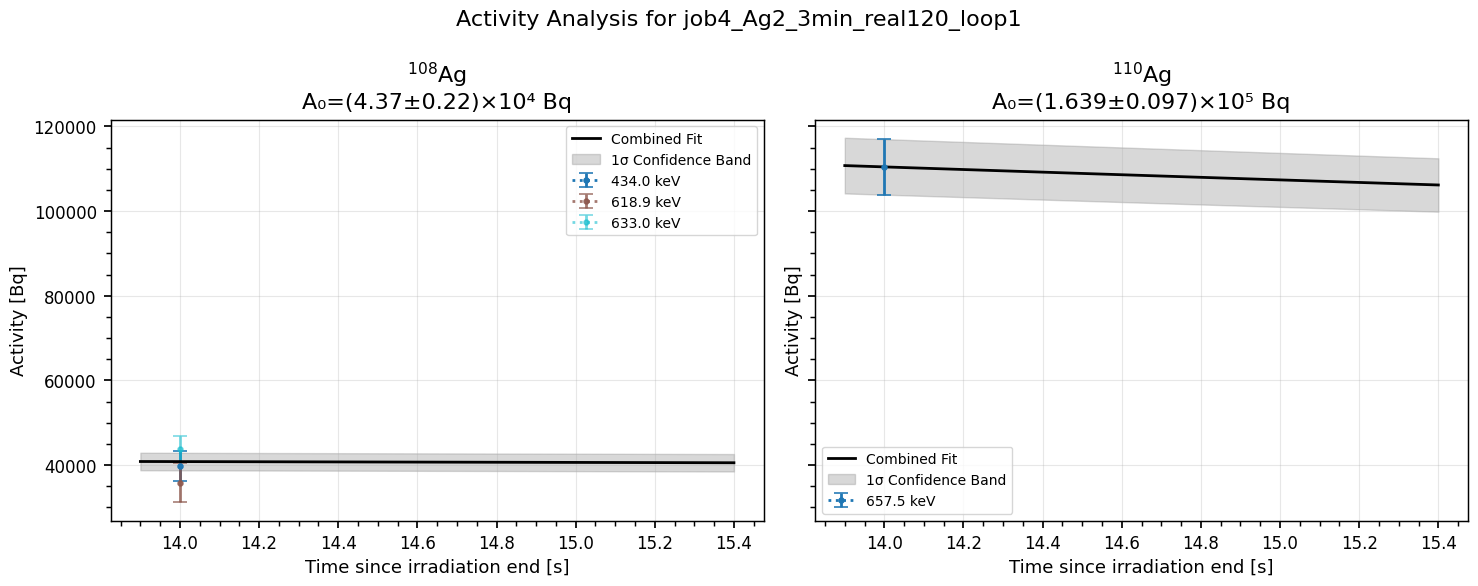

In [16]:
analysis_4.plot_activity()

### Job 5:
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

In [17]:
analysis_5 = SpectrumAnalysis(spec_exp_path / 'job5_Ag4_3min_real5_loop6', Δt_d=7)

FileNotFoundError: First loop of spectrum file not found: c:\Users\krist\Dokumenter\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_000.Spe

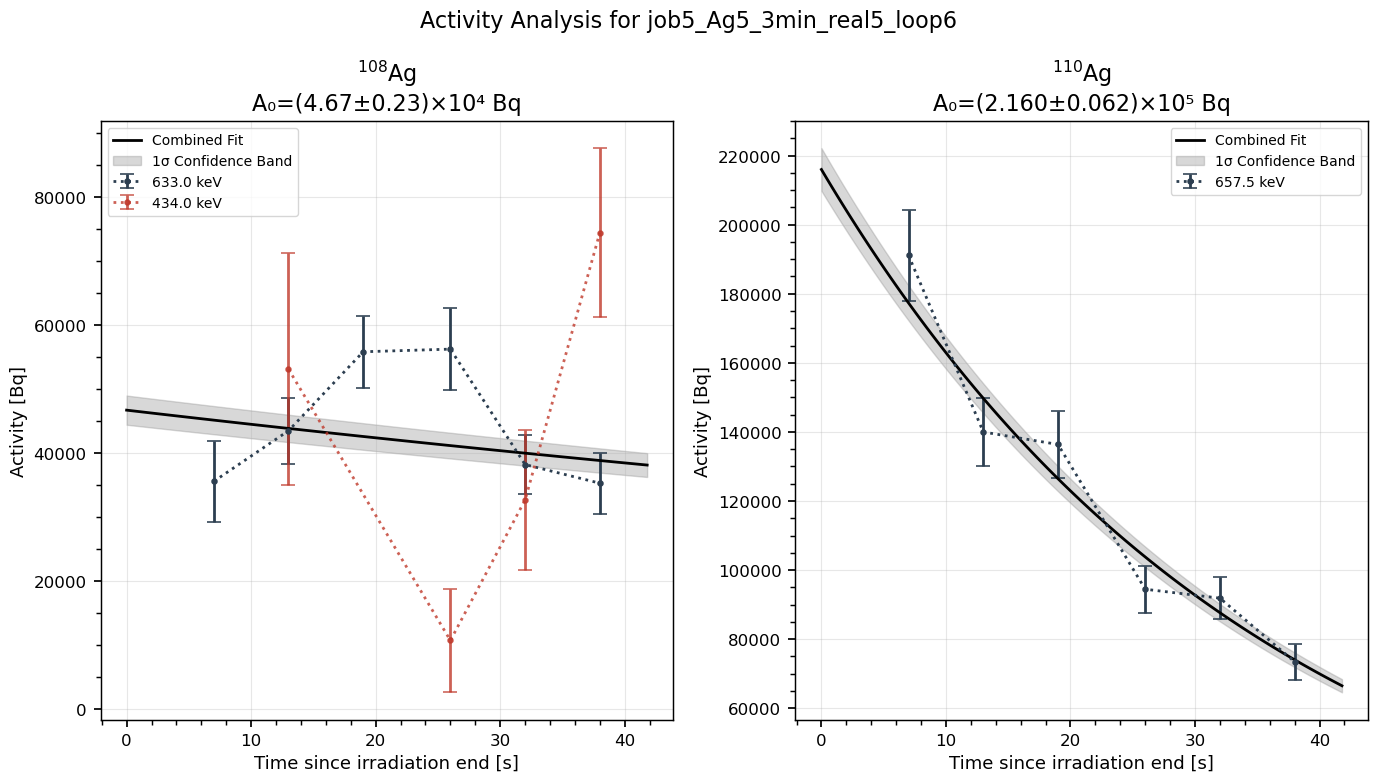

In [ ]:
analysis_5.plot_activity()

In [18]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    plt.errorbar(irr, _A0, yerr=A0_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, A0_values_108, linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    plt.errorbar(irr, _A0, yerr=A0_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, A0_values_110, linestyle=':')
    
plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Initial activity as a function of irradiation time')
plt.tight_layout()
# plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.pdf')
# plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.png')
plt.show()

NameError: name 'analysis_5' is not defined

In [19]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    λ = ci.Isotope('108AG').decay_const()
    R = _A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds # type: ignore
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate # type: ignore
    plt.errorbar(irr, R, yerr=R_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_108, irradiation_times)], linestyle=':') # type: ignore

plt.xlabel('Irradation time [min]')
plt.ylabel('Production Rate R [Bq/s]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    λ = ci.Isotope('110AG').decay_const()
    R = _A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds # type: ignore
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate # type: ignore
    plt.errorbar(irr, R, yerr=R_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_110, irradiation_times)], linestyle=':') # type: ignore

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Production rate as a function of irradiation time')
plt.tight_layout()
# plt.savefig(fig_path / 'production_rate_vs_irradiation_time.pdf')
# plt.savefig(fig_path / 'production_rate_vs_irradiation_time.png')
plt.show()

NameError: name 'analysis_5' is not defined

# Part 2: Cross Sections

## Possible Product Nuclides

- Target foils:
  - $^{\text{nat}}\text{Ga}$
  - $^{\text{nat}}\text{Sn}$
- Monitor foils: 
  - $^{\text{nat}}\text{Ni}$
  - $^{\text{nat}}\text{Cu}$

### Target Nuclides

#### $^{\text{nat}}\text{Ga}$ (Gallium)

- 64,65,66,67,68,69,70,71,72 Ge
- 63,64,65,66,67,68,69,70,71 Ga
- 62,63,64,65,66,67,68,69,70 Zn 
- 61,62,63,64,65,66,67,68,69 Cu
- 60,61,62,63,64,65,66,67,68 Ni
- 59,60,61,62,63,64,65,66,67 Co 
- 58,59,60,61,62,63,64,65,66 Fe

In [21]:
csa_Ga = CrossSectionAnalysis(target='Ga', particle_beam='proton', n_alpha=3, max_half_life=100, min_half_life=60, grayzone_half_life=10)

csa_Ga.isotope_overview(copy_to_clipboard=True, print_markdown=True)

Found 22/63 isotopes for observation:
64Cu 65Ni 69Zn 67Cu 71Ge 67Ga 70Ga 65Zn 66Ni 61Cu 62Zn 61Co 65Ga 67Ge 68Ga 66Ga 69Ge 66Ge 60Co 63Zn 68Ge 59Fe

Found 8/63 grayzone isotopes:
62Cu 62Co 69Cu 64Ga 61Fe 66Cu 62Fe 64Ge
Found 22/63 isotopes for observation:
64Cu 65Ni 69Zn 67Cu 71Ge 67Ga 70Ga 65Zn 66Ni 61Cu 62Zn 61Co 65Ga 67Ge 68Ga 66Ga 69Ge 66Ge 60Co 63Zn 68Ge 59Fe

Found 8/63 grayzone isotopes:
62Cu 62Co 69Cu 64Ga 61Fe 66Cu 62Fe 64Ge

Markdown table copied to clipboard.
| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 72Ge      | Stable      | ✘        |
| 71Ge      | 11 d        | ✔        |
| 70Ge      | Stable      | ✘        |
| 69Ge      | 1.6 d       | ✔        |
| 68Ge      | 2.7e+02 d   | ✔        |
| 67Ge      | 19 m        | ✔        |
| 66Ge      | 2.3 h       | ✔        |
| 65Ge      | 31 s        | ✘        |
| 64Ge      | 1.1 m       | ~        |
| 71Ga      | Stable      | ✘        |
| 70Ga      | 21 m        | ✔        |
| 69Ga      | Stab

,Isotope,Half-life,Status
0,72Ge,Stable,✘
1,71Ge,11 d,✔
2,70Ge,Stable,✘
3,69Ge,1.6 d,✔
4,68Ge,2.7e+02 d,✔
...,...,...,...
58,62Fe,1.1 m,~
59,61Fe,6 m,~
60,60Fe,1.5e+06 y,✘
61,59Fe,44 d,✔


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 72Ge      | Stable      | ✘          | ✔              | ✘                |
| 71Ge      | 11 d        | ✔          | ✘              | ✘                |
| 70Ge      | Stable      | ✘          | ✔              | ✘                |
| 69Ge      | 1.6 d       | ✔          | ✘              | ✘                |
| 68Ge      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 67Ge      | 19 m        | ✔          | ✘              | ✘                |
| 66Ge      | 2.3 h       | ✔          | ✘              | ✘                |
| 65Ge      | 31 s        | ✘          | ✔              | ✘                |
| 64Ge      | 1.1 m       | ✘          | ✘              | ✔                |
| 71Ga      | Stable      | ✘          | ✔              | ✘                |
| 70Ga      | 21 m        | ✔          | ✘              | ✘                |
| 69Ga      | Stable      | ✘          | ✔              | ✘                |
| 68Ga      | 1.1 h       | ✔          | ✘              | ✘                |
| 67Ga      | 3.3 d       | ✔          | ✘              | ✘                |
| 66Ga      | 9.5 h       | ✔          | ✘              | ✘                |
| 65Ga      | 15 m        | ✔          | ✘              | ✘                |
| 64Ga      | 2.6 m       | ✘          | ✘              | ✔                |
| 63Ga      | 32 s        | ✘          | ✔              | ✘                |
| 70Zn      | 1e+03 ns    | ✘          | ✔              | ✘                |
| 69Zn      | 56 m        | ✔          | ✘              | ✘                |
| 68Zn      | Stable      | ✘          | ✔              | ✘                |
| 67Zn      | Stable      | ✘          | ✔              | ✘                |
| 66Zn      | Stable      | ✘          | ✔              | ✘                |
| 65Zn      | 2.4e+02 d   | ✔          | ✘              | ✘                |
| 64Zn      | Stable      | ✘          | ✔              | ✘                |
| 63Zn      | 38 m        | ✔          | ✘              | ✘                |
| 62Zn      | 9.3 h       | ✔          | ✘              | ✘                |
| 69Cu      | 2.9 m       | ✘          | ✘              | ✔                |
| 68Cu      | 31 s        | ✘          | ✔              | ✘                |
| 67Cu      | 2.6 d       | ✔          | ✘              | ✘                |
| 66Cu      | 5.1 m       | ✘          | ✘              | ✔                |
| 65Cu      | Stable      | ✘          | ✔              | ✘                |
| 64Cu      | 13 h        | ✔          | ✘              | ✘                |
| 63Cu      | Stable      | ✘          | ✔              | ✘                |
| 62Cu      | 9.7 m       | ✘          | ✘              | ✔                |
| 61Cu      | 3.3 h       | ✔          | ✘              | ✘                |
| 68Ni      | 29 s        | ✘          | ✔              | ✘                |
| 67Ni      | 21 s        | ✘          | ✔              | ✘                |
| 66Ni      | 2.3 d       | ✔          | ✘              | ✘                |
| 65Ni      | 2.5 h       | ✔          | ✘              | ✘                |
| 64Ni      | Stable      | ✘          | ✔              | ✘                |
| 63Ni      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62Ni      | Stable      | ✘          | ✔              | ✘                |
| 61Ni      | Stable      | ✘          | ✔              | ✘                |
| 60Ni      | Stable      | ✘          | ✔              | ✘                |
| 67Co      | 4.2e+02 ms  | ✘          | ✔              | ✘                |
| 66Co      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 65Co      | 1.2 s       | ✘          | ✔              | ✘                |
| 64Co      | 3e+02 ms    | ✘          | ✔              | ✘                |
| 63Co      | 27 s        | ✘          | ✔              | ✘                |
| 62Co      | 1.5 m       | ✘          | ✘              | ✔                |
| 61Co      | 1.6 h       | ✔          | ✘              | ✘                |
| 60Co      | 5.3 y       | ✔          | ✘              | ✘                |
| 59Co      | Stable      | ✘          | ✔              | ✘                |
| 66Fe      | 4.4e+02 ms  | ✘          | ✔              | ✘                |
| 65Fe      | 8.1e+02 ms  | ✘          | ✔              | ✘                |
| 64Fe      | 2 s         | ✘          | ✔              | ✘                |
| 63Fe      | 6.1 s       | ✘          | ✔              | ✘                |
| 62Fe      | 1.1 m       | ✘          | ✘              | ✔                |
| 61Fe      | 6 m         | ✘          | ✘              | ✔                |
| 60Fe      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59Fe      | 44 d        | ✔          | ✘              | ✘                |
| 58Fe      | Stable      | ✘          | ✔              | ✘                |

#### $^{\text{nat}}\text{Sn}$ (Tin)

- 107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125 Sb
- 106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124 Sn 
- 105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123 In  
- 104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122 Cd 
- 103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121 Ag
- 102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120 Pd
- 101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119 Rh

In [22]:
csa_Sn = CrossSectionAnalysis(target='Sn')

csa_Sn.isotope_overview(copy_to_clipboard=True)

Found 45/133 isotopes for observation:
120Sb 110In 121Sn 108In 109Cd 107In 109In 122Sb 113Ag 104Cd 116Sb 110Sn 111Ag 115Ag 109Pd 109Sn 103Ag 101Rh 102Rh 112Ag 105Rh 112Pd 111Pd 112In 103Pd 125Sb 111Sn 107Cd 108Sn 113Sn 119Sb 123Sn 105Ag 107Rh 117Sb 115Cd 106Ag 115Sb 117In 111In 118Cd 117Cd 124Sb 104Ag 105Cd

Found 17/133 grayzone isotopes:
109Rh 114In 114Sb 108Ag 111Sb 113Pd 119In 106Sn 113Sb 105In 118Sb 107Sn 116Ag 119Cd 106In 117Ag 114Pd
Found 45/133 isotopes for observation:
120Sb 110In 121Sn 108In 109Cd 107In 109In 122Sb 113Ag 104Cd 116Sb 110Sn 111Ag 115Ag 109Pd 109Sn 103Ag 101Rh 102Rh 112Ag 105Rh 112Pd 111Pd 112In 103Pd 125Sb 111Sn 107Cd 108Sn 113Sn 119Sb 123Sn 105Ag 107Rh 117Sb 115Cd 106Ag 115Sb 117In 111In 118Cd 117Cd 124Sb 104Ag 105Cd

Found 17/133 grayzone isotopes:
109Rh 114In 114Sb 108Ag 111Sb 113Pd 119In 106Sn 113Sb 105In 118Sb 107Sn 116Ag 119Cd 106In 117Ag 114Pd

Markdown table copied to clipboard.


,Isotope,Half-life,Status
0,125Sb,2.8 y,✔
1,124Sb,60 d,✔
2,123Sb,Stable,✘
3,122Sb,2.7 d,✔
4,121Sb,Stable,✘
...,...,...,...
128,105Rh,1.5 d,✔
129,104Rh,42 s,✘
130,103Rh,Stable,✘
131,102Rh,2.1e+02 d,✔


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 125Sb     | 2.8 y       | ✔          | ✘              | ✘                |
| 124Sb     | 60 d        | ✔          | ✘              | ✘                |
| 123Sb     | Stable      | ✘          | ✔              | ✘                |
| 122Sb     | 2.7 d       | ✔          | ✘              | ✘                |
| 121Sb     | Stable      | ✘          | ✔              | ✘                |
| 120Sb     | 16 m        | ✔          | ✘              | ✘                |
| 119Sb     | 1.6 d       | ✔          | ✘              | ✘                |
| 118Sb     | 3.6 m       | ✘          | ✘              | ✔                |
| 117Sb     | 2.8 h       | ✔          | ✘              | ✘                |
| 116Sb     | 16 m        | ✔          | ✘              | ✘                |
| 115Sb     | 32 m        | ✔          | ✘              | ✘                |
| 114Sb     | 3.5 m       | ✘          | ✘              | ✔                |
| 113Sb     | 6.7 m       | ✘          | ✘              | ✔                |
| 112Sb     | 51 s        | ✘          | ✔              | ✘                |
| 111Sb     | 1.2 m       | ✘          | ✘              | ✔                |
| 110Sb     | 23 s        | ✘          | ✔              | ✘                |
| 109Sb     | 17 s        | ✘          | ✔              | ✘                |
| 108Sb     | 7.4 s       | ✘          | ✔              | ✘                |
| 107Sb     | 4 s         | ✘          | ✔              | ✘                |
| 124Sn     | Stable      | ✘          | ✔              | ✘                |
| 123Sn     | 1.3e+02 d   | ✔          | ✘              | ✘                |
| 122Sn     | Stable      | ✘          | ✔              | ✘                |
| 121Sn     | 1.1 d       | ✔          | ✘              | ✘                |
| 120Sn     | Stable      | ✘          | ✔              | ✘                |
| 119Sn     | Stable      | ✘          | ✔              | ✘                |
| 118Sn     | Stable      | ✘          | ✔              | ✘                |
| 117Sn     | Stable      | ✘          | ✔              | ✘                |
| 116Sn     | Stable      | ✘          | ✔              | ✘                |
| 115Sn     | Stable      | ✘          | ✔              | ✘                |
| 114Sn     | Stable      | ✘          | ✔              | ✘                |
| 113Sn     | 1.2e+02 d   | ✔          | ✘              | ✘                |
| 112Sn     | Stable      | ✘          | ✔              | ✘                |
| 111Sn     | 35 m        | ✔          | ✘              | ✘                |
| 110Sn     | 4.1 h       | ✔          | ✘              | ✘                |
| 109Sn     | 18 m        | ✔          | ✘              | ✘                |
| 108Sn     | 10 m        | ✔          | ✘              | ✘                |
| 107Sn     | 2.9 m       | ✘          | ✘              | ✔                |
| 106Sn     | 1.9 m       | ✘          | ✘              | ✔                |
| 123In     | 6.2 s       | ✘          | ✔              | ✘                |
| 122In     | 1.5 s       | ✘          | ✔              | ✘                |
| 121In     | 23 s        | ✘          | ✔              | ✘                |
| 120In     | 3.1 s       | ✘          | ✔              | ✘                |
| 119In     | 2.4 m       | ✘          | ✘              | ✔                |
| 118In     | 5 s         | ✘          | ✔              | ✘                |
| 117In     | 43 m        | ✔          | ✘              | ✘                |
| 116In     | 14 s        | ✘          | ✔              | ✘                |
| 115In     | 4.4e+14 y   | ✘          | ✔              | ✘                |
| 114In     | 1.2 m       | ✘          | ✘              | ✔                |
| 113In     | Stable      | ✘          | ✔              | ✘                |
| 112In     | 15 m        | ✔          | ✘              | ✘                |
| 111In     | 2.8 d       | ✔          | ✘              | ✘                |
| 110In     | 4.9 h       | ✔          | ✘              | ✘                |
| 109In     | 4.2 h       | ✔          | ✘              | ✘                |
| 108In     | 58 m        | ✔          | ✘              | ✘                |
| 107In     | 32 m        | ✔          | ✘              | ✘                |
| 106In     | 6.2 m       | ✘          | ✘              | ✔                |
| 105In     | 5.1 m       | ✘          | ✘              | ✔                |
| 122Cd     | 5.2 s       | ✘          | ✔              | ✘                |
| 121Cd     | 14 s        | ✘          | ✔              | ✘                |
| 120Cd     | 51 s        | ✘          | ✔              | ✘                |
| 119Cd     | 2.7 m       | ✘          | ✘              | ✔                |
| 118Cd     | 50 m        | ✔          | ✘              | ✘                |
| 117Cd     | 2.5 h       | ✔          | ✘              | ✘                |
| 116Cd     | 3.1e+19 y   | ✘          | ✔              | ✘                |
| 115Cd     | 2.2 d       | ✔          | ✘              | ✘                |
| 114Cd     | Stable      | ✘          | ✔              | ✘                |
| 113Cd     | 8e+15 y     | ✘          | ✔              | ✘                |
| 112Cd     | Stable      | ✘          | ✔              | ✘                |
| 111Cd     | Stable      | ✘          | ✔              | ✘                |
| 110Cd     | Stable      | ✘          | ✔              | ✘                |
| 109Cd     | 1.3 y       | ✔          | ✘              | ✘                |
| 108Cd     | Stable      | ✘          | ✔              | ✘                |
| 107Cd     | 6.5 h       | ✔          | ✘              | ✘                |
| 106Cd     | Stable      | ✘          | ✔              | ✘                |
| 105Cd     | 56 m        | ✔          | ✘              | ✘                |
| 104Cd     | 58 m        | ✔          | ✘              | ✘                |
| 121Ag     | 7.8e+02 ms  | ✘          | ✔              | ✘                |
| 120Ag     | 1.2 s       | ✘          | ✔              | ✘                |
| 119Ag     | 2.1 s       | ✘          | ✔              | ✘                |
| 118Ag     | 3.8 s       | ✘          | ✔              | ✘                |
| 117Ag     | 1.2 m       | ✘          | ✘              | ✔                |
| 116Ag     | 4 m         | ✘          | ✘              | ✔                |
| 115Ag     | 20 m        | ✔          | ✘              | ✘                |
| 114Ag     | 4.6 s       | ✘          | ✔              | ✘                |
| 113Ag     | 5.4 h       | ✔          | ✘              | ✘                |
| 112Ag     | 3.1 h       | ✔          | ✘              | ✘                |
| 111Ag     | 7.5 d       | ✔          | ✘              | ✘                |
| 110Ag     | 25 s        | ✘          | ✔              | ✘                |
| 109Ag     | Stable      | ✘          | ✔              | ✘                |
| 108Ag     | 2.4 m       | ✘          | ✘              | ✔                |
| 107Ag     | Stable      | ✘          | ✔              | ✘                |
| 106Ag     | 24 m        | ✔          | ✘              | ✘                |
| 105Ag     | 41 d        | ✔          | ✘              | ✘                |
| 104Ag     | 1.2 h       | ✔          | ✘              | ✘                |
| 103Ag     | 1.1 h       | ✔          | ✘              | ✘                |
| 120Pd     | 5e+02 ms    | ✘          | ✔              | ✘                |
| 119Pd     | 9.2e+02 ms  | ✘          | ✔              | ✘                |
| 118Pd     | 1.9 s       | ✘          | ✔              | ✘                |
| 117Pd     | 4.3 s       | ✘          | ✔              | ✘                |
| 116Pd     | 12 s        | ✘          | ✔              | ✘                |
| 115Pd     | 25 s        | ✘          | ✔              | ✘                |
| 114Pd     | 2.4 m       | ✘          | ✘              | ✔                |
| 113Pd     | 1.6 m       | ✘          | ✘              | ✔                |
| 112Pd     | 21 h        | ✔          | ✘              | ✘                |
| 111Pd     | 23 m        | ✔          | ✘              | ✘                |
| 110Pd     | Stable      | ✘          | ✔              | ✘                |
| 109Pd     | 14 h        | ✔          | ✘              | ✘                |
| 108Pd     | Stable      | ✘          | ✔              | ✘                |
| 107Pd     | 6.5e+06 y   | ✘          | ✔              | ✘                |
| 106Pd     | Stable      | ✘          | ✔              | ✘                |
| 105Pd     | Stable      | ✘          | ✔              | ✘                |
| 104Pd     | Stable      | ✘          | ✔              | ✘                |
| 103Pd     | 17 d        | ✔          | ✘              | ✘                |
| 102Pd     | Stable      | ✘          | ✔              | ✘                |
| 119Rh     | 1.7e+02 ms  | ✘          | ✔              | ✘                |
| 118Rh     | 2.7e+02 ms  | ✘          | ✔              | ✘                |
| 117Rh     | 4.4e+02 ms  | ✘          | ✔              | ✘                |
| 116Rh     | 6.8e+02 ms  | ✘          | ✔              | ✘                |
| 115Rh     | 9.9e+02 ms  | ✘          | ✔              | ✘                |
| 114Rh     | 1.9 s       | ✘          | ✔              | ✘                |
| 113Rh     | 2.8 s       | ✘          | ✔              | ✘                |
| 112Rh     | 2.1 s       | ✘          | ✔              | ✘                |
| 111Rh     | 11 s        | ✘          | ✔              | ✘                |
| 110Rh     | 3.2 s       | ✘          | ✔              | ✘                |
| 109Rh     | 1.3 m       | ✘          | ✘              | ✔                |
| 108Rh     | 17 s        | ✘          | ✔              | ✘                |
| 107Rh     | 22 m        | ✔          | ✘              | ✘                |
| 106Rh     | 30 s        | ✘          | ✔              | ✘                |
| 105Rh     | 1.5 d       | ✔          | ✘              | ✘                |
| 104Rh     | 42 s        | ✘          | ✔              | ✘                |
| 103Rh     | Stable      | ✘          | ✔              | ✘                |
| 102Rh     | 2.1e+02 d   | ✔          | ✘              | ✘                |
| 101Rh     | 3.3 y       | ✔          | ✘              | ✘                |

### Monitor Foils

#### $^{\text{nat}}\text{Cu}$ (Copper)

- 58,59,60,61,62,63,64,65,66 Zn
- 57,58,59,60,61,62,63,64,65 Cu
- 56,57,58,59,60,61,62,63,64 Ni 
- 55,56,57,58,59,60,61,62,63 Co
- 54,55,56,57,58,59,60,61,62 Fe
- 53,54,55,56,57,58,59,60,61 Mn
- 52,53,54,55,56,57,58,59,60 Cr

In [23]:
csa_Cu = CrossSectionAnalysis(target='Cu')

csa_Cu.isotope_overview(copy_to_clipboard=True)

Found 18/63 isotopes for observation:
64Cu 58Co 54Mn 56Co 65Zn 56Mn 61Cu 62Zn 61Co 60Cu 57Co 55Fe 57Ni 60Co 63Zn 55Co 56Ni 59Fe

Found 10/63 grayzone isotopes:
62Cu 55Cr 60Zn 56Cr 57Mn 59Cu 61Fe 61Zn 62Fe 62Co
Found 18/63 isotopes for observation:
64Cu 58Co 54Mn 56Co 65Zn 56Mn 61Cu 62Zn 61Co 60Cu 57Co 55Fe 57Ni 60Co 63Zn 55Co 56Ni 59Fe

Found 10/63 grayzone isotopes:
62Cu 55Cr 60Zn 56Cr 57Mn 59Cu 61Fe 61Zn 62Fe 62Co

Markdown table copied to clipboard.


,Isotope,Half-life,Status
0,66Zn,Stable,✘
1,65Zn,2.4e+02 d,✔
2,64Zn,Stable,✘
3,63Zn,38 m,✔
4,62Zn,9.3 h,✔
...,...,...,...
58,56Cr,5.9 m,~
59,55Cr,3.5 m,~
60,54Cr,Stable,✘
61,53Cr,Stable,✘


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 66ZN      | Stable      | ✘          | ✔              | ✘                |
| 65ZN      | 2.4e+02 d   | ✔          | ✘              | ✘                |
| 64ZN      | Stable      | ✘          | ✔              | ✘                |
| 63ZN      | 38 m        | ✔          | ✘              | ✘                |
| 62ZN      | 9.3 h       | ✔          | ✘              | ✘                |
| 61ZN      | 1.5 m       | ✘          | ✘              | ✔                |
| 60ZN      | 2.4 m       | ✘          | ✘              | ✔                |
| 59ZN      | 1.8e+02 ms  | ✘          | ✔              | ✘                |
| 58ZN      | 84 ms       | ✘          | ✔              | ✘                |
| 65CU      | Stable      | ✘          | ✔              | ✘                |
| 64CU      | 13 h        | ✔          | ✘              | ✘                |
| 63CU      | Stable      | ✘          | ✔              | ✘                |
| 62CU      | 9.7 m       | ✘          | ✘              | ✔                |
| 61CU      | 3.3 h       | ✔          | ✘              | ✘                |
| 60CU      | 24 m        | ✔          | ✘              | ✘                |
| 59CU      | 1.4 m       | ✘          | ✘              | ✔                |
| 58CU      | 3.2 s       | ✘          | ✔              | ✘                |
| 57CU      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 64NI      | Stable      | ✘          | ✔              | ✘                |
| 63NI      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62NI      | Stable      | ✘          | ✔              | ✘                |
| 61NI      | Stable      | ✘          | ✔              | ✘                |
| 60NI      | Stable      | ✘          | ✔              | ✘                |
| 59NI      | 7.6e+04 y   | ✘          | ✔              | ✘                |
| 58NI      | Stable      | ✘          | ✔              | ✘                |
| 57NI      | 1.5 d       | ✔          | ✘              | ✘                |
| 56NI      | 6.1 d       | ✔          | ✘              | ✘                |
| 63CO      | 27 s        | ✘          | ✔              | ✘                |
| 62CO      | 1.5 m       | ✘          | ✘              | ✔                |
| 61CO      | 1.6 h       | ✔          | ✘              | ✘                |
| 60CO      | 5.3 y       | ✔          | ✘              | ✘                |
| 59CO      | Stable      | ✘          | ✔              | ✘                |
| 58CO      | 71 d        | ✔          | ✘              | ✘                |
| 57CO      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 56CO      | 77 d        | ✔          | ✘              | ✘                |
| 55CO      | 18 h        | ✔          | ✘              | ✘                |
| 62FE      | 1.1 m       | ✘          | ✘              | ✔                |
| 61FE      | 6 m         | ✘          | ✘              | ✔                |
| 60FE      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59FE      | 44 d        | ✔          | ✘              | ✘                |
| 58FE      | Stable      | ✘          | ✔              | ✘                |
| 57FE      | Stable      | ✘          | ✔              | ✘                |
| 56FE      | Stable      | ✘          | ✔              | ✘                |
| 55FE      | 2.7 y       | ✔          | ✘              | ✘                |
| 54FE      | Stable      | ✘          | ✔              | ✘                |
| 61MN      | 6.7e+02 ms  | ✘          | ✔              | ✘                |
| 60MN      | 51 s        | ✘          | ✔              | ✘                |
| 59MN      | 4.6 s       | ✘          | ✔              | ✘                |
| 58MN      | 3 s         | ✘          | ✔              | ✘                |
| 57MN      | 1.4 m       | ✘          | ✘              | ✔                |
| 56MN      | 2.6 h       | ✔          | ✘              | ✘                |
| 55MN      | Stable      | ✘          | ✔              | ✘                |
| 54MN      | 3.1e+02 d   | ✔          | ✘              | ✘                |
| 53MN      | 3.7e+06 y   | ✘          | ✔              | ✘                |
| 60CR      | 4.9e+02 ms  | ✘          | ✔              | ✘                |
| 59CR      | 4.6e+02 ms  | ✘          | ✔              | ✘                |
| 58CR      | 7 s         | ✘          | ✔              | ✘                |
| 57CR      | 21 s        | ✘          | ✔              | ✘                |
| 56CR      | 5.9 m       | ✘          | ✘              | ✔                |
| 55CR      | 3.5 m       | ✘          | ✘              | ✔                |
| 54CR      | Stable      | ✘          | ✔              | ✘                |
| 53CR      | Stable      | ✘          | ✔              | ✘                |
| 52CR      | Stable      | ✘          | ✔              | ✘                |

#### $^{\text{nat}}\text{Ni}$ (Nickel)

- 53,54,55,56,57,58,59,60,61,62,63,64,65 Cu 
- 52,53,54,55,56,57,58,59,60,61,62,63,64 Ni 
- 51,52,53,54,55,56,57,58,59,60,61,62,63 Co
- 50,51,52,53,54,55,56,57,58,59,60,61,62 Fe
- 49,50,51,52,53,54,55,56,57,58,59,60,61 Mn 
- 48,49,50,51,52,53,54,55,56,57,58,59,60 Cr
- 47,48,49,50,51,52,53,54,55,56,57,58,59 V

In [24]:
csa_Ni = CrossSectionAnalysis(target='Ni')

csa_Ni.isotope_overview(copy_to_clipboard=True)

Found 24/91 isotopes for observation:
54Mn 49Cr 49V 48Cr 48V 57Co 56Co 61Cu 55Fe 55Co 56Ni 64Cu 58Co 56Mn 52Mn 47V 59Fe 52Fe 51Mn 61Co 60Cu 57Ni 60Co 51Cr

Found 11/91 grayzone isotopes:
62Cu 57Mn 52V 55Cr 56Cr 53V 62Co 53Fe 61Fe 62Fe 59Cu
Found 24/91 isotopes for observation:
54Mn 49Cr 49V 48Cr 48V 57Co 56Co 61Cu 55Fe 55Co 56Ni 64Cu 58Co 56Mn 52Mn 47V 59Fe 52Fe 51Mn 61Co 60Cu 57Ni 60Co 51Cr

Found 11/91 grayzone isotopes:
62Cu 57Mn 52V 55Cr 56Cr 53V 62Co 53Fe 61Fe 62Fe 59Cu

Markdown table copied to clipboard.


,Isotope,Half-life,Status
0,65Cu,Stable,✘
1,64Cu,13 h,✔
2,63Cu,Stable,✘
3,62Cu,9.7 m,~
4,61Cu,3.3 h,✔
...,...,...,...
86,51V,Stable,✘
87,50V,1.4e+17 y,✘
88,49V,3.3e+02 d,✔
89,48V,16 d,✔


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 65Cu      | Stable      | ✘          | ✔              | ✘                |
| 64Cu      | 13 h        | ✔          | ✘              | ✘                |
| 63Cu      | Stable      | ✘          | ✔              | ✘                |
| 62Cu      | 9.7 m       | ✘          | ✘              | ✔                |
| 61Cu      | 3.3 h       | ✔          | ✘              | ✘                |
| 60Cu      | 24 m        | ✔          | ✘              | ✘                |
| 59Cu      | 1.4 m       | ✘          | ✘              | ✔                |
| 58Cu      | 3.2 s       | ✘          | ✔              | ✘                |
| 57Cu      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 56Cu      | 94 ms       | ✘          | ✔              | ✘                |
| 55Cu      | 40 ms       | ✘          | ✔              | ✘                |
| 54Cu      | 75 ns       | ✘          | ✔              | ✘                |
| 53Cu      | 3e+02 ns    | ✘          | ✔              | ✘                |
| 64Ni      | Stable      | ✘          | ✔              | ✘                |
| 63Ni      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62Ni      | Stable      | ✘          | ✔              | ✘                |
| 61Ni      | Stable      | ✘          | ✔              | ✘                |
| 60Ni      | Stable      | ✘          | ✔              | ✘                |
| 59Ni      | 7.6e+04 y   | ✘          | ✔              | ✘                |
| 58Ni      | Stable      | ✘          | ✔              | ✘                |
| 57Ni      | 1.5 d       | ✔          | ✘              | ✘                |
| 56Ni      | 6.1 d       | ✔          | ✘              | ✘                |
| 55Ni      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 54Ni      | 1e+02 ms    | ✘          | ✔              | ✘                |
| 53Ni      | 45 ms       | ✘          | ✔              | ✘                |
| 52Ni      | 38 ms       | ✘          | ✔              | ✘                |
| 63Co      | 27 s        | ✘          | ✔              | ✘                |
| 62Co      | 1.5 m       | ✘          | ✘              | ✔                |
| 61Co      | 1.6 h       | ✔          | ✘              | ✘                |
| 60Co      | 5.3 y       | ✔          | ✘              | ✘                |
| 59Co      | Stable      | ✘          | ✔              | ✘                |
| 58Co      | 71 d        | ✔          | ✘              | ✘                |
| 57Co      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 56Co      | 77 d        | ✔          | ✘              | ✘                |
| 55Co      | 18 h        | ✔          | ✘              | ✘                |
| 54Co      | 1.9e+02 ms  | ✘          | ✔              | ✘                |
| 53Co      | 2.4e+02 ms  | ✘          | ✔              | ✘                |
| 52Co      | 1.2e+02 ms  | ✘          | ✔              | ✘                |
| 51Co      | 2e+02 ns    | ✘          | ✔              | ✘                |
| 62Fe      | 1.1 m       | ✘          | ✘              | ✔                |
| 61Fe      | 6 m         | ✘          | ✘              | ✔                |
| 60Fe      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59Fe      | 44 d        | ✔          | ✘              | ✘                |
| 58Fe      | Stable      | ✘          | ✔              | ✘                |
| 57Fe      | Stable      | ✘          | ✔              | ✘                |
| 56Fe      | Stable      | ✘          | ✔              | ✘                |
| 55Fe      | 2.7 y       | ✔          | ✘              | ✘                |
| 54Fe      | Stable      | ✘          | ✔              | ✘                |
| 53Fe      | 8.5 m       | ✘          | ✘              | ✔                |
| 52Fe      | 8.3 h       | ✔          | ✘              | ✘                |
| 51Fe      | 3e+02 ms    | ✘          | ✔              | ✘                |
| 50Fe      | 1.6e+02 ms  | ✘          | ✔              | ✘                |
| 61Mn      | 6.7e+02 ms  | ✘          | ✔              | ✘                |
| 60Mn      | 51 s        | ✘          | ✔              | ✘                |
| 59Mn      | 4.6 s       | ✘          | ✔              | ✘                |
| 58Mn      | 3 s         | ✘          | ✔              | ✘                |
| 57Mn      | 1.4 m       | ✘          | ✘              | ✔                |
| 56Mn      | 2.6 h       | ✔          | ✘              | ✘                |
| 55Mn      | Stable      | ✘          | ✔              | ✘                |
| 54Mn      | 3.1e+02 d   | ✔          | ✘              | ✘                |
| 53Mn      | 3.7e+06 y   | ✘          | ✔              | ✘                |
| 52Mn      | 5.6 d       | ✔          | ✘              | ✘                |
| 51Mn      | 46 m        | ✔          | ✘              | ✘                |
| 50Mn      | 2.8e+02 ms  | ✘          | ✔              | ✘                |
| 49Mn      | 3.8e+02 ms  | ✘          | ✔              | ✘                |
| 60Cr      | 4.9e+02 ms  | ✘          | ✔              | ✘                |
| 59Cr      | 4.6e+02 ms  | ✘          | ✔              | ✘                |
| 58Cr      | 7 s         | ✘          | ✔              | ✘                |
| 57Cr      | 21 s        | ✘          | ✔              | ✘                |
| 56Cr      | 5.9 m       | ✘          | ✘              | ✔                |
| 55Cr      | 3.5 m       | ✘          | ✘              | ✔                |
| 54Cr      | Stable      | ✘          | ✔              | ✘                |
| 53Cr      | Stable      | ✘          | ✔              | ✘                |
| 52Cr      | Stable      | ✘          | ✔              | ✘                |
| 51Cr      | 28 d        | ✔          | ✘              | ✘                |
| 50Cr      | Stable      | ✘          | ✔              | ✘                |
| 49Cr      | 42 m        | ✔          | ✘              | ✘                |
| 48Cr      | 22 h        | ✔          | ✘              | ✘                |
| 59V       | 75 ms       | ✘          | ✔              | ✘                |
| 58V       | 1.8e+02 ms  | ✘          | ✔              | ✘                |
| 57V       | 3.5e+02 ms  | ✘          | ✔              | ✘                |
| 56V       | 2.2e+02 ms  | ✘          | ✔              | ✘                |
| 55V       | 6.5 s       | ✘          | ✔              | ✘                |
| 54V       | 50 s        | ✘          | ✔              | ✘                |
| 53V       | 1.5 m       | ✘          | ✘              | ✔                |
| 52V       | 3.7 m       | ✘          | ✘              | ✔                |
| 51V       | Stable      | ✘          | ✔              | ✘                |
| 50V       | 1.4e+17 y   | ✘          | ✔              | ✘                |
| 49V       | 3.3e+02 d   | ✔          | ✘              | ✘                |
| 48V       | 16 d        | ✔          | ✘              | ✘                |
| 47V       | 33 m        | ✔          | ✘              | ✘                |

## Finding Good Cross Sections

### Target Foils Cross Sections

#### Ga (Gallium)

In [ ]:
# csa_Ga.save_tendl_data(path = tendl_data_path / 'Ga')

In [25]:
(fig_path / 'cross_section_analysis').mkdir(parents=True, exist_ok=True)

Found 21/21 isotopes with cross-sections above 0.01 mb:
69Ge 68Ga 67Ga 71Ge 68Ge 65Zn 66Ga 70Ga 67Ge 65Ga 64Cu 63Zn 69Zn 66Ge 62Zn 67Cu 60Co 61Cu 65Ni 61Co 66Ni


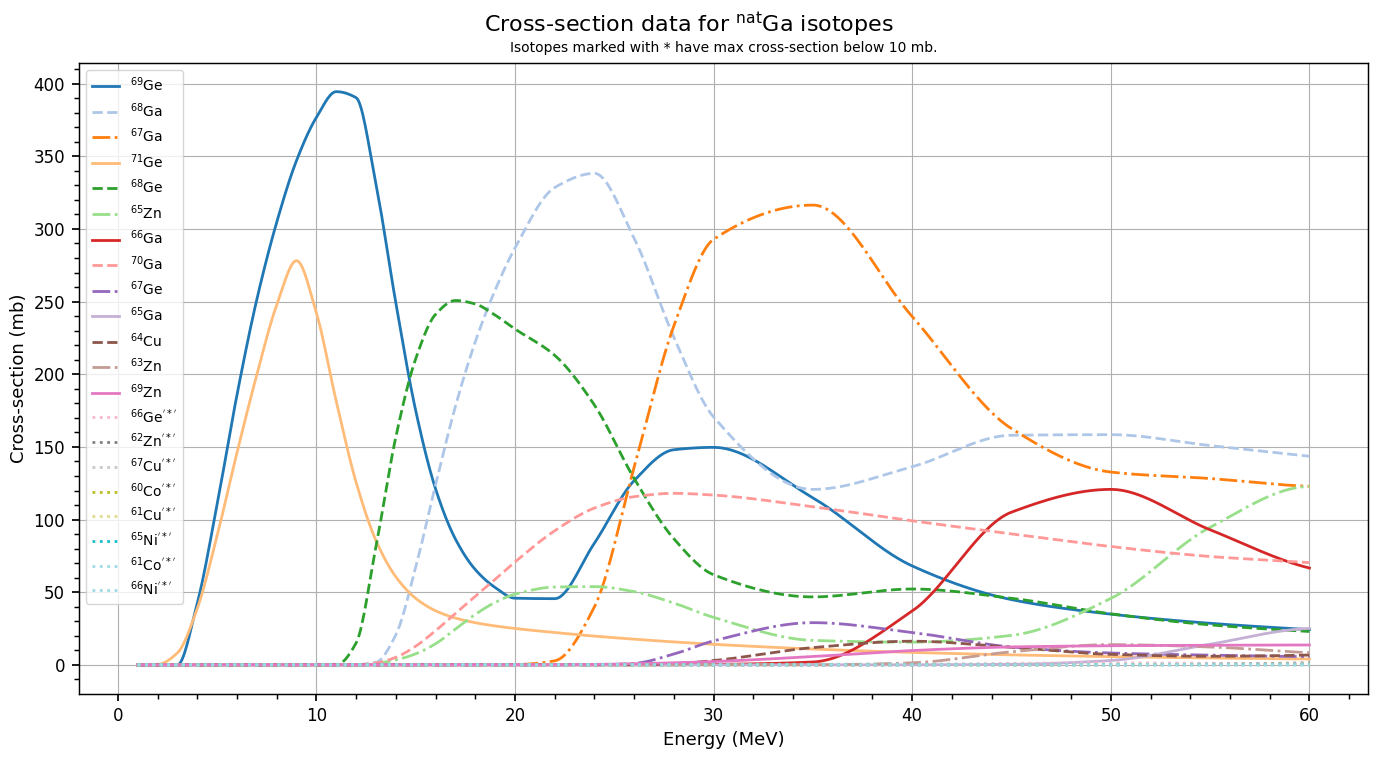

In [26]:
csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga')


sorted_filtered_isotopes_Ga = csa_Ga.filter_products_Cs(Cs_threshold=1e-2, E_limit=60, E_beam=None)
csa_Ga.plot_Cs(title=r'Cross-section data for $^{\text{nat}}$Ga isotopes', isotopes=sorted_filtered_isotopes_Ga, low_Cs_threshold=10)
plt.savefig(fig_path / 'cross_section_analysis' / 'Ga_filtered_Cs.pdf')
plt.show()

Found 5/5 isotopes with cross-sections above 0.01 mb:
62Cu 66Cu 69Cu 64Ga 62Co


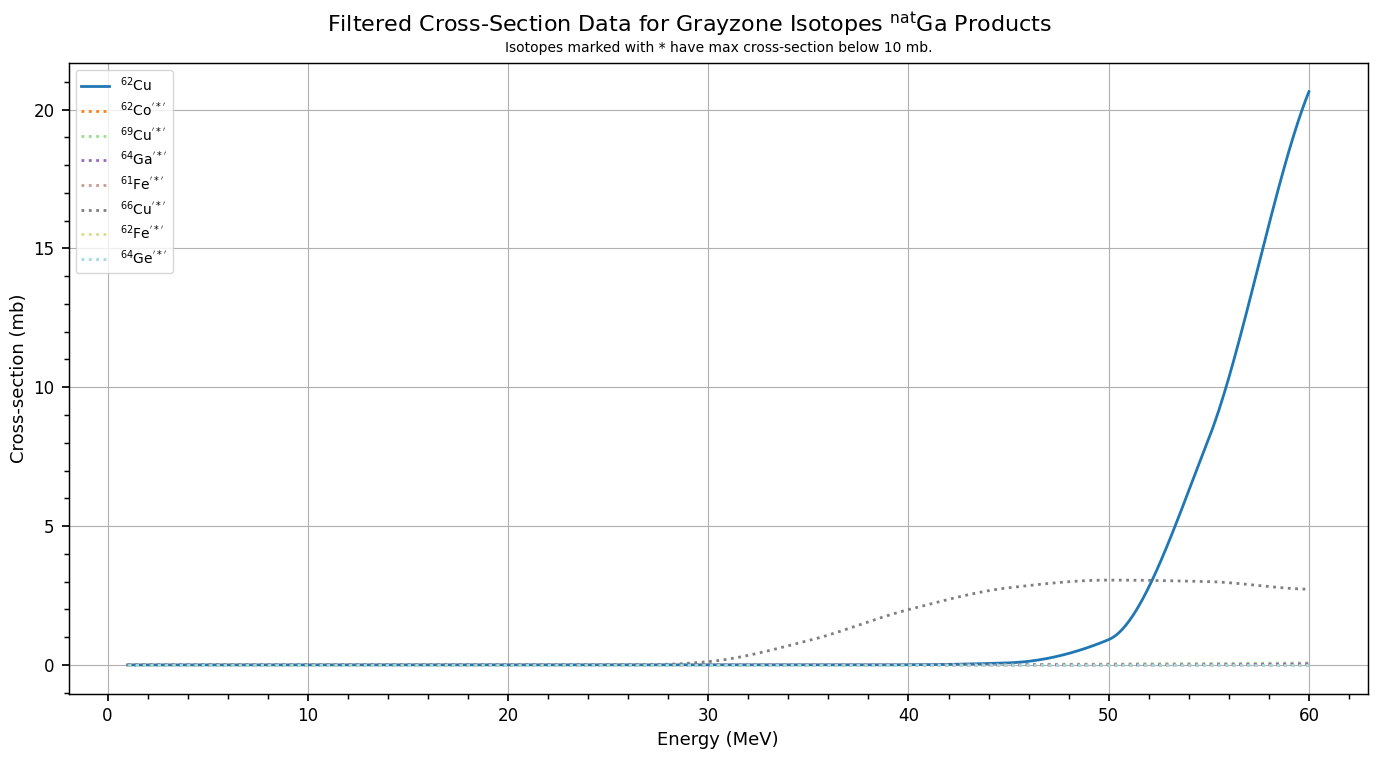

In [27]:
grayzone_products_Ga = csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga', isotopes=csa_Ga.grayzone_isotopes)

sorted_filtered_grayzone_isotopes_Ga = csa_Ga.filter_products_Cs(isotopes=grayzone_products_Ga['Name'], Cs_threshold=1e-2, E_limit=60, E_beam=None)

csa_Ga.plot_Cs(title=r'Filtered Cross-Section Data for Grayzone Isotopes $^{\text{nat}}$Ga Products', isotopes=grayzone_products_Ga)
plt.savefig(fig_path / 'Ga_grayzone_filtered_Cs.pdf')
plt.show()

#### Sn (Tin)

In [ ]:
# csa_Sn.save_tendl_data(path = tendl_data_path / 'Sn')

Found 31/31 isotopes with cross-sections above 0.01 mb:
119Sb 117Sb 120Sb 116Sb 115Sb 113Sn 122Sb 121Sn 124Sb 117In 123Sn 111Sn 112In 111In 110In 110Sn 109In 109Sn 109Cd 108In 107In 108Sn 107Cd 115Cd 105Cd 125Sb 106Ag 111Ag 117Cd 118Cd 105Ag


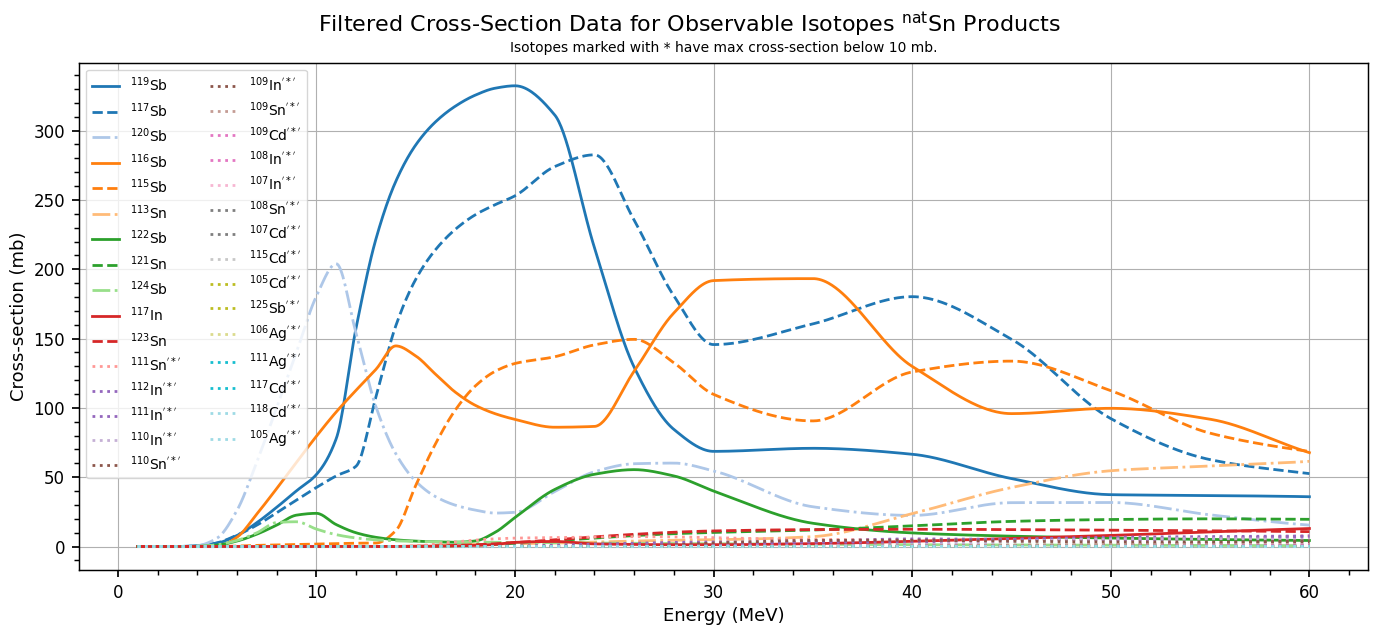

In [28]:
csa_Sn.load_tendl_data(path = tendl_data_path / 'Sn')

sorted_filtered_isotopes_Sn = csa_Sn.filter_products_Cs()
csa_Sn.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Sn Products', isotopes=sorted_filtered_isotopes_Sn)
plt.legend(loc='upper left', ncol=2)
plt.savefig(fig_path / 'Sn_filtered_Cs.pdf')
plt.show()

### Monitor Foils Cross Sections

#### Cu (Copper)

In [ ]:
# csa_Cu.save_tendl_data(path = tendl_data_path / 'Cu')

Found 18/18 isotopes with cross-sections above 0.01 mb:
63Zn 65Zn 61Cu 64Cu 62Zn 57Co 58Co 60Cu 60Co 56Co 57Ni 55Fe 61Co 54Mn 59Fe 56Mn 56Ni 55Co


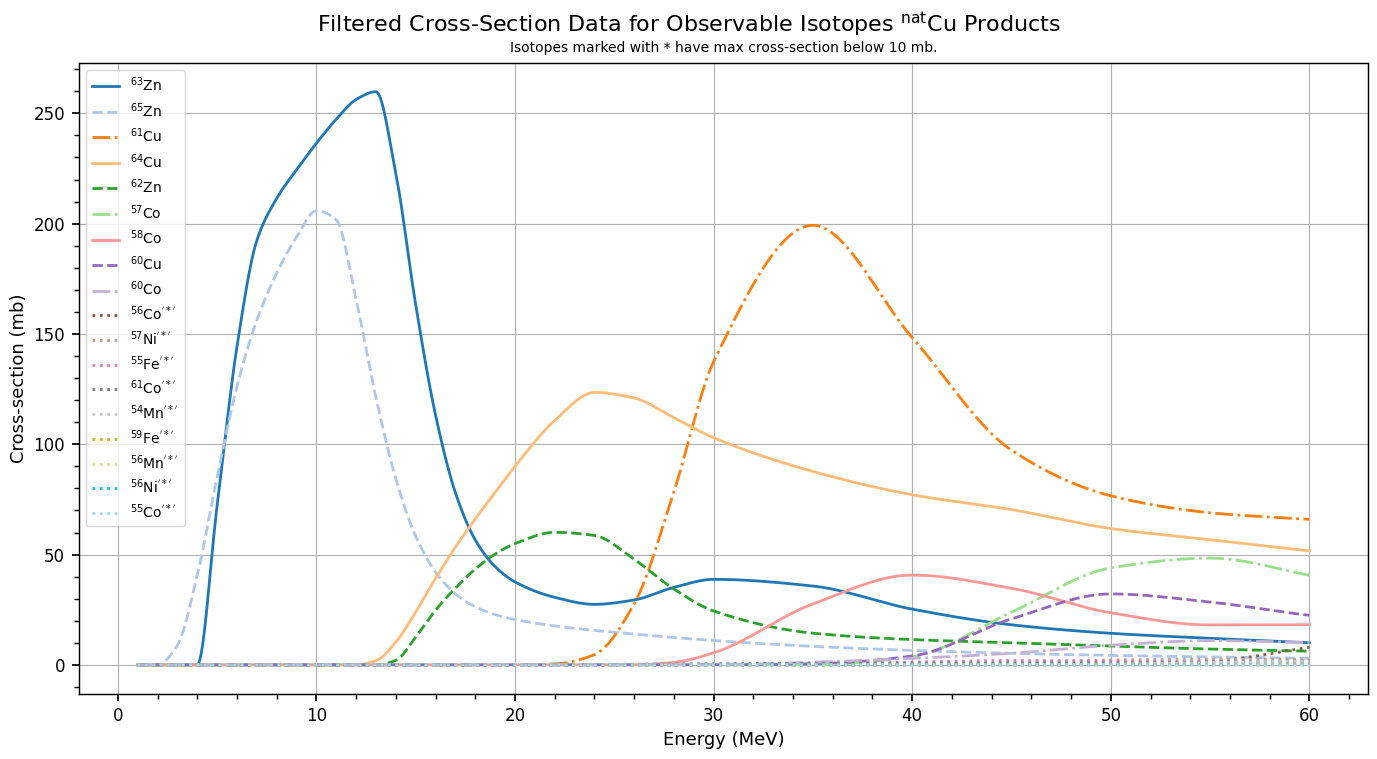

In [29]:
csa_Cu.load_tendl_data(path = tendl_data_path / 'Cu')

sorted_filtered_isotopes_Cu = csa_Cu.filter_products_Cs()
csa_Cu.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Cu Products', isotopes=sorted_filtered_isotopes_Cu)
plt.savefig(fig_path / 'Cu_filtered_Cs.pdf')
plt.show()

#### Ni (Nickel)

In [ ]:
# csa_Ni.save_tendl_data(path = tendl_data_path / 'Ni')

Found 21/21 isotopes with cross-sections above 0.01 mb:
57Co 56Co 57Ni 55Fe 60Cu 58Co 55Co 52Mn 56Ni 61Cu 54Mn 64Cu 60Co 51Cr 61Co 52Fe 51Mn 49V 49Cr 59Fe 56Mn


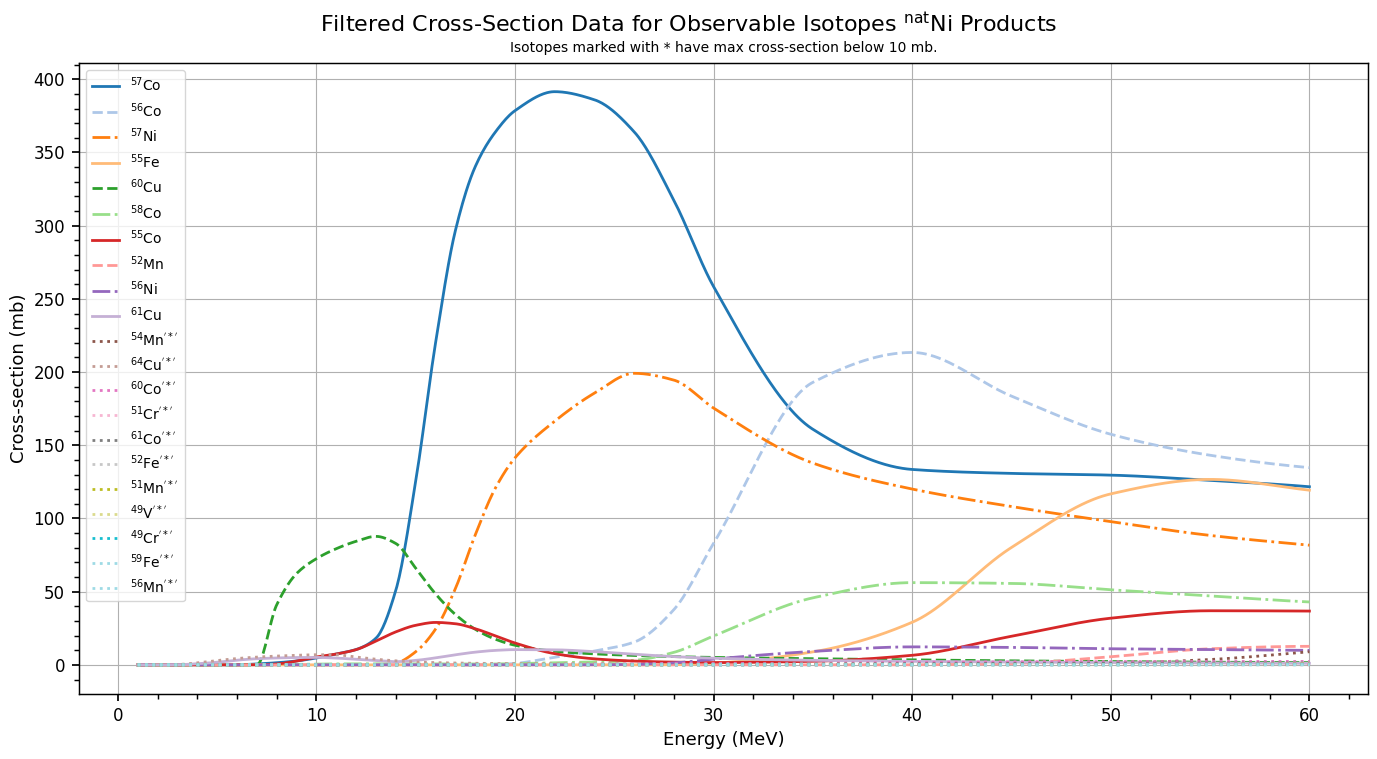

In [30]:
csa_Ni.load_tendl_data(path = tendl_data_path / 'Ni')

sorted_filtered_isotopes_Ni = csa_Ni.filter_products_Cs()
csa_Ni.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Ni Products', isotopes=sorted_filtered_isotopes_Ni)
plt.savefig(fig_path / 'Ni_filtered_Cs.pdf')
plt.show()

# Part 3: Calculating Counting Times

In [43]:
## Compound must be specified, and enough info to determine areal density
## Units:
## thickness: mm
## mass: g
## area: cm^2
## ad (areal density): mg/cm^2
## density: g/cm^3

x_kapton = 0.013
x_silicone = 0.013

ad_degrader_a = 599.   #2.24 mm
ad_degrader_b = 415.0   #1.55 mm
ad_degrader_c = 261.5   #0.97 mm
# ad_degrader_d = 599.0
ad_degrader_e = 68.3   #0.256 mm
ad_degrader_h = 33.8

ad_be_backing = 4.425     #23.9130435 microns

# for i in np.arange(1,11):
# 	print(i)

# 
# 55 MeV stack
# 

stack = []
for i,mult in zip(np.arange(1,8),[ad_degrader_c,ad_degrader_c,ad_degrader_c,ad_degrader_c,3*ad_degrader_e,3*ad_degrader_e,3*ad_degrader_e]):
    d = [
    {'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
            {'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
            {'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
            {'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
            {'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
    # print(d)
    stack = stack + d
    # stack.update(d)

# 
# 30 MeV stack
# 

# stack = []
# for i,mult in zip(np.arange(8,15),[2*ad_degrader_e,2*ad_degrader_e,2*ad_degrader_e,ad_degrader_e,ad_degrader_e,68.75,0.01]):
# 	d = [{'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
# 			{'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
# 			{'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
# 	# print(d)
# 	stack = stack+ d
# 	# stack.update(d)

# print(stack)


# # cm = ci.Compound('RbF', density=3.56)
# # print(cm.weights)


# print('Running...')
# # st = ci.Stack(stack, compounds={'RbF':{'Cu':-66, 'Zn':-33}}, E0=60.0)

st = ci.Stack(stack, E0=55.0, particle='p', dE0=0.55, N=1E4, max_steps=100)
# st = ci.Stack(stack, E0=30.0, particle='p', dE0=0.30, N=1E4, max_steps=100)
# st.saveas('lbnl_GaSn_stack_30MeV.csv')
# st.saveas('lbnl_GaSn_stack_30MeV.db')
# st.saveas('lbnl_GaSn_stack_55MeV.csv')
# st.saveas('lbnl_GaSn_stack_55MeV.db')
# # st.saveas('lbnl_w_stack.db')
# # st.saveas('lbnl_pa_stack.csv')
# st.summarize()
print(st.stack.columns)
st.plot('Ga')

ValueError: '28' is not in list

In [32]:
Φ = 6.24e11  # Proton flux in protons/cm^2/s
t_irr = 60 * 60  # Irradiation time in seconds (1

sa = StackAnalysis(st, efficiency_func=cb.eff, proton_flux=Φ, irradiation_time=t_irr)

NameError: name 'st' is not defined

In [33]:
products = {'Ga': sorted_filtered_isotopes_Ga,
            'Sn': sorted_filtered_isotopes_Sn,
            'Cu': sorted_filtered_isotopes_Cu,
            'Ni': sorted_filtered_isotopes_Ni}

results = sa.analyze(products=products, t_d=np.arange(0, 60*60*24*3), t_max=60*60, min_intensity=10.0, dE_511=0.1, silent=True)
print(results.head())

NameError: name 'sa' is not defined

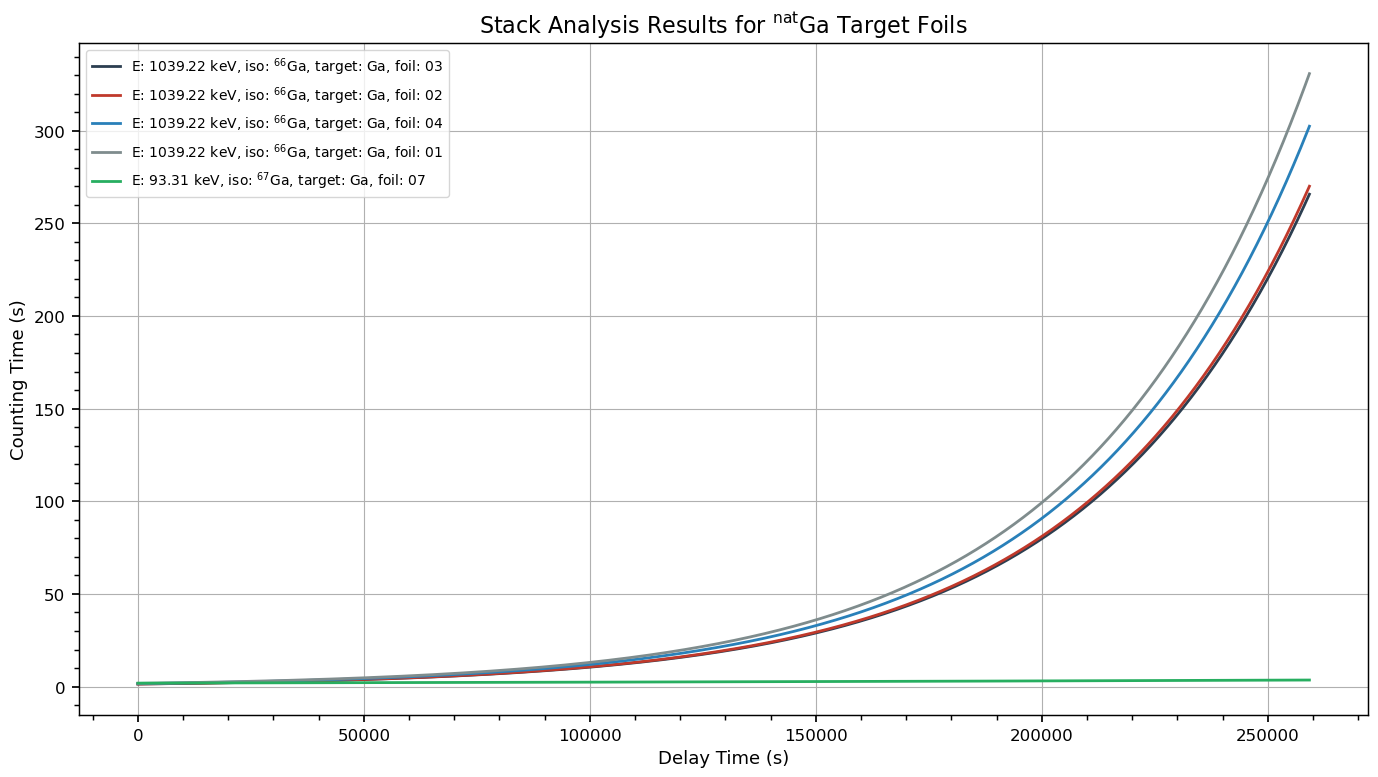

In [ ]:
sa.plot(results, target='Ga', title=r'Stack Analysis Results for $^{\text{nat}}$Ga Target Foils')
plt.show()